from functions import *
import pandas as pd
from pathlib import Path
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

**Read in the data for table generation**

In [ ]:
# secretion = pd.read_csv('E:\\blastp_hits\\dl_endo_signalp.txt', sep='\t')

# dl_map = pd.read_csv('../../data/clustering/cluster_maps/dl_endopeptidase.tsv', sep='\t')

# taxonomy = pd.read_csv('E:\\blastp_hits\\taxonomy_mapping.tsv', sep='\t')

# uniref_genome = pd.read_csv('E:\\blastp_hits\\uniref_genome_map.txt', sep='\t', header=None, names=['Genome', 'Uniref'])

# interpro = pd.read_csv('E:\\blastp_hits\\all_dl_ips.tsv', sep='\t', header=None)

# print(interpro.head(), interpro.shape)
# print(secretion.head(), secretion.shape)
# print(dl_map.head(), dl_map.shape)
# print(taxonomy.head(), taxonomy.shape)
# print(uniref_genome.head(), uniref_genome.shape)

In [ ]:
# Clean the secretion file to include genome IDs and predicitons

secretion['# ID'] = secretion['# ID'].str.split('#').str[0].str.strip()

secretion['Genome'] = secretion['# ID'].str.split('_').str[0]

secretion = secretion[['# ID', 'Genome', 'Prediction']]

secretion['Genome'] = secretion['Genome'].str.strip('.fa')

# secretion = secretion.rename(columns={'# ID': 'Genome'})

# IDs have extra indicators like this: MGYG000155050_27_22 not found in the mapping file. strip themn off for now 

display(secretion.head()) 

In [ ]:
# Clean the uniref map add names to columns

uniref_genome.rename(columns={'Genome': '# ID'}, inplace=True)

uniref_genome['# ID'] = uniref_genome['# ID'].str.strip()

# uniref_genome['Genome'] = uniref_genome['# ID'].str.split('_').str[0]

uniref_genome['Uniref'] = uniref_genome['Uniref'].str.split('_').str[1]

display(uniref_genome.head())


In [ ]:
taxonomy['Genome'] = taxonomy['Genome'].str.strip('.fa')

display(taxonomy.head())

In [ ]:
# Merge the secretion data with the uniref map data

secretion_and_uniref = secretion.merge(uniref_genome, on='# ID', how='inner')

display(secretion_and_uniref.head())

In [ ]:
# Merge the secretion and taxonomy data with the uniref_genome data

dle_info = secretion_and_uniref.merge(taxonomy, on='Genome', how='inner')

display(dle_info.head())

In [ ]:
# clean ips table

interpro = interpro.iloc[:, [0, 12]]

interpro.head()

In [ ]:
interpro.rename(columns={0: '# ID', 12: 'Interpro'}, inplace=True)

interpro.head()

In [ ]:
interpro = interpro.groupby(['# ID']).agg(list).reset_index()

display(interpro.head())

In [ ]:
print(dle_info.shape, interpro.shape)

dle_info = dle_info.merge(interpro, on='# ID', how='left')

print(dle_info.shape)

In [ ]:
dl_map.rename(columns={'dl_endopeptidase-unclustered': 'Uniref'}, inplace=True)

display(dl_map.head())

**Old Code might re-use**

In [2]:
def pie_chart(taxa_info: list):
    
    # Get taxa info for pie charts
    phyla = []
    family = []
    genus = []
    for tax in taxa_info:
        phyla.append(tax.split(';')[1].replace('p__', ''))
        family.append((tax.split(';')[4]).replace('f__', ''))
        genus.append(tax.split(';')[-2].replace('g__', ''))

    phyla_counts = Counter(phyla)
    family_counts = Counter(family)
    genus_counts = Counter(genus)

    # Create pie charts

    sns.set_style('whitegrid')

    # Create a figure to hold the subplots
    plt.figure(figsize=(24, 12))

    # Phyla Distribution
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    plt.pie(phyla_counts.values(), labels=phyla_counts.keys(), autopct='%1.1f%%')
    plt.title('Phyla Distribution')

    # Family Distribution
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    plt.pie(family_counts.values(), labels=family_counts.keys(), autopct='%1.1f%%')
    plt.title('Family Distribution')

    # Genus Distribution
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    plt.pie(genus_counts.values(), labels=genus_counts.keys(), autopct='%1.1f%%')
    plt.title('Genus Distribution')

    # Show the figure with the subplots
    plt.tight_layout()
    plt.show()

    #in future add code to save figure as png

In [3]:
def bar_chart(domain_info: list, secretion_info: list, number_proteins: int):


    domain_counter = Counter(domain_info)
    
    secretion_counter = Counter(secretion_info)

    # Calculate average domain/protein
    domain_average = {key: (value / number_proteins) for key, value in domain_counter.items()}

    # Calculate percent secretion

    secretion_percent = {key: (value / number_proteins) * 100 for key, value in secretion_counter.items()}

    # # Debugging: Print labels and their corresponding percentages
    # for key, value in domain_average.items():
    #     print(f"{key}: {value}%")

    # Preparing data for plotting
    domain_labels = list(domain_average.keys())
    domain_percentages = list(domain_average.values())

    secretion_labels = list(secretion_percent.keys())
    secretion_percentages = list(secretion_percent.values())


    with warnings.catch_warnings():
        # plotting warning regarding palette and hue can be ignored for now
        warnings.simplefilter("ignore", FutureWarning)

        # Set a larger font size for all plot elements
        sns.set_context("talk")

        # Set style
        sns.set_style('whitegrid')

        # Create a larger figure to accommodate the subplots
        plt.figure(figsize=(24, 12))

        # Domain Distribution
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        domain_plot = sns.barplot(x=domain_labels, y=domain_percentages, palette="Blues_d", edgecolor='black', linewidth=2)
        plt.title('Average # Domains per Protein', fontsize=20)
        plt.xlabel('Domains', fontsize=18)
        plt.ylabel('Domain per Protein', fontsize=18)  # Adding label for clarity
        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14)

        # Secretion Distribution
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        secretion_plot = sns.barplot(x=secretion_labels, y=secretion_percentages, palette="Greens_d", edgecolor='black', linewidth=2)
        plt.title('Secretion Distribution', fontsize=20)
        plt.xlabel('Secretion Systems', fontsize=18)
        plt.ylabel('Percentage of Cluster Members')  # Intentionally left blank as per your setup
        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14)

        # Adjust the layout
        plt.tight_layout()

        # Show the plot
        plt.show()



In [4]:
# Now map is created, need to make a function to quickly index clusters and pull important
# information from the table. Get: number species, taxa info, secretion percentage
def describe_cluster(cluster_id: str, protein_info_table: Path, cluster_info_table: Path):
    """
    This function takes a cluster ID and a table of information about the clusters and returns
    the number of species, the taxa information, and the percentage of the cluster that is predicted
    to be secreted. 
    """

    # Read in tables as dfs
    cluster_info_table = pd.read_csv(cluster_info_table, sep='\t')
    protein_info_table = pd.read_csv(protein_info_table, sep='\t')

    # given the cluster_id, find the initial uniref IDs and make them into a list
    clustered_dl_list = list(cluster_info_table.loc[cluster_info_table['dl_endopeptidase-foldseek_cluster'] == cluster_id, 'Uniref'])

    number_proteins = len(list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), '# ID']))

    # search the protein_info_table for the reuturned Uniref ids. return unique species
    species_list = list(set(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Lineage']))

    # feed species list into species_pie_chart function to get figure

    # Find percentage of proteins that are secreted

    secretion_list = list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Prediction'])

    # Get domain information and normalize to per protein

    # select the domain info column and make it into a list
    domain_info = list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Interpro'])

    # flatten the list
    domain_info = [item for sublist in domain_info for item in (sublist if isinstance(sublist, list) else [sublist])]

    # remove any NA values
    domain_info = [item for item in domain_info if not pd.isna(item)]

    # convert strings to lists
    domain_info = [ast.literal_eval(item) for item in domain_info]

    # flatten the list
    domain_info = [item for sublist in domain_info for item in (sublist if isinstance(sublist, list) else [sublist])]

    # domain_info = {k: v / number_proteins for k, v in domain_info.items()}

    # print(domain_info)

    return(pie_chart(species_list), bar_chart(domain_info, secretion_list, number_proteins))
  

In [ ]:
print(describe_cluster('A0A348AMN4', 'E:\\blastp_hits\\dl_endo_info.tsv', 'E:\\blastp_hits\\dl_endo_cluster_map.tsv'))

**The domain infographics look good but might not be showing the best information. For example, how many proteins dont have the domain at all? How many have 2 copies of the domain?**

In [24]:
# function to caluculate the proportion of secretion from each cluster, return it as a table

def secretion(cluster_ids, protein_info_table: Path, cluster_info_table: Path):

    # Read in tables as dfs
    cluster_info_table = pd.read_csv(cluster_info_table, sep='\t')
    protein_info_table = pd.read_csv(protein_info_table, sep='\t')

    secretion_proportion_table = pd.DataFrame(columns=['Cluster ID', 'Secreted', 'Non-Secreted'])
    
    for cluster_id in cluster_ids:
        # given the cluster_id, find the initial uniref IDs and make them into a list
        clustered_dl_list = list(cluster_info_table.loc[cluster_info_table['dl_endopeptidase-foldseek_cluster'] == cluster_id, 'Uniref'])

        number_proteins = len(list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), '# ID']))

        if number_proteins > 0:

            secretion_list = list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Prediction'])

            secretion_counter = Counter(secretion_list)

            # print(secretion_counter)

            # Create a new row DataFrame
            new_row = pd.DataFrame([{
                'Cluster ID': cluster_id, 
                'Secreted': (secretion_counter['SP'] / number_proteins), 
                'Non-Secreted': (secretion_counter['OTHER'] / number_proteins)
            }])

        else:
            print(f"Cluster {cluster_id} has no proteins")
            
        # Use concat to add the new row to the secretion_proportion_table DataFrame
        secretion_proportion_table = pd.concat([secretion_proportion_table, new_row], ignore_index=True)

    return secretion_proportion_table

In [25]:
cluster_ids = ['R6MIH8', 'A0A1C5PVP3', 'A0A1C6G745']

print(secretion(cluster_ids, 'E:\\blastp_hits\\dl_endo_info.tsv', 'E:\\blastp_hits\\dl_endo_cluster_map.tsv'))

   Cluster ID  Secreted  Non-Secreted
0      R6MIH8  0.000000      1.000000
1  A0A1C5PVP3  0.978782      0.021218
2  A0A1C6G745  0.820743      0.179257


C:\Users\odesa\AppData\Local\Temp\ipykernel_17748\3550645430.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  secretion_proportion_table = pd.concat([secretion_proportion_table, new_row], ignore_index=True)


In [26]:
with open('DLE_ids.txt' , 'r') as file:
    cluster_ids = file.readlines()

cluster_ids = [x.split('.')[2].strip() for x in cluster_ids]
print(cluster_ids)

['R7C958', 'A0A1C6G745', 'A0A829ZMP2', 'A0A1C6FAW9', 'C0D0G2', 'A0A174TDS3', 'R6MIH8', 'A0A1C5VJV2', 'A0A0B0HUJ2', 'A0A6N2TU31', 'A0A132I0H7', 'R6YTV6', 'A0A1C5PVP3', 'R7HVK1', 'A0A7U9SHV5', 'A0A4R7RUE4', 'A0A1Y6AQ80', 'R5N6Z6', 'A0A174M4B0', 'A0A1C5KNH6', 'A0A1V6BVN9', 'A0A348AMN4', 'A0A518C016', 'A0A1C5KMM8', 'A0A1I0DL10', 'A0A564W7U7', 'A0A6N3I5I0', 'R5ATJ0', 'A0A6N3BHG0', 'A0A1I3GQ51', 'A0A1C5Q6A7', 'A0A0P8W7Z2', 'A0A1V5YPB2', 'A0A174CGJ4', 'A0A1C5WD06', 'A0A259UPD7']


In [28]:
secretion_table = secretion(cluster_ids, 'E:\\blastp_hits\\dl_endo_info.tsv', 'E:\\blastp_hits\\dl_endo_cluster_map.tsv')

C:\Users\odesa\AppData\Local\Temp\ipykernel_17748\3550645430.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  secretion_proportion_table = pd.concat([secretion_proportion_table, new_row], ignore_index=True)


Cluster A0A564W7U7 has no proteins


In [29]:
downregulated = ['A0A1C6G745', 'R6MIH8', 'A0A1C6FAW9', 'A0A1C5VJV2', 'R6YTV6', 'A0A829ZMP2']

In [30]:
secretion_table['downregulated'] = secretion_table['Cluster ID'].isin(downregulated).astype(int)

display(secretion_table)


,Cluster ID,Secreted,Non-Secreted,downregulated
0,R7C958,0.680773,0.184913,0
1,A0A1C6G745,0.820743,0.179257,1
2,A0A829ZMP2,0.816849,0.183151,1
3,A0A1C6FAW9,1.000000,0.000000,1
4,C0D0G2,0.159039,0.240561,0
5,A0A174TDS3,0.894697,0.105303,0
6,R6MIH8,0.000000,1.000000,1
7,A0A1C5VJV2,0.500000,0.500000,1
8,A0A0B0HUJ2,0.000000,1.000000,0
9,A0A6N2TU31,0.347942,0.648074,0


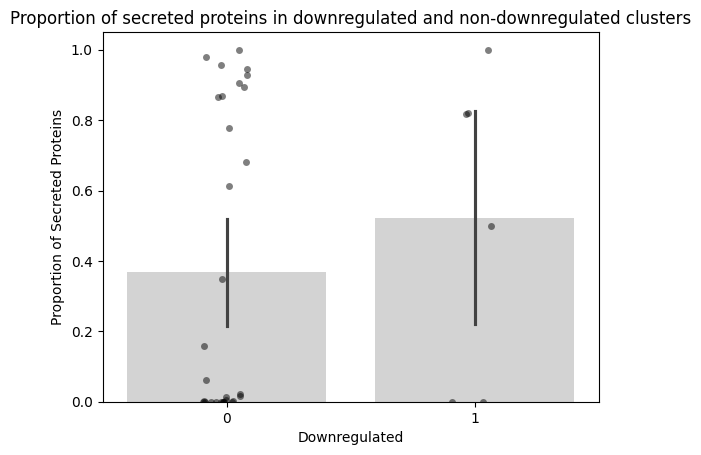

In [44]:
# Plotting boxplot
sns.barplot(x='downregulated', y='Secreted', data=secretion_table, color='lightgrey')

# Overlaying individual points with stripplot
sns.stripplot(x='downregulated', y='Secreted', data=secretion_table, jitter=True, dodge=True, marker='o', alpha=0.5, color='black')

plt.title('Proportion of secreted proteins in downregulated and non-downregulated clusters')
plt.xlabel('Downregulated')
plt.ylabel('Proportion of Secreted Proteins')
plt.show()

In [36]:
from scipy.stats import mannwhitneyu, shapiro, ttest_ind

# Splitting the dataset based on downregulated status
group1 = secretion_table[secretion_table['downregulated'] == 0]['Secreted']
group2 = secretion_table[secretion_table['downregulated'] == 1]['Secreted']

# Mann-Whitney U test
stat, p = mannwhitneyu(group1, group2)

print('Mann-Whitney U Test statistics=%.3f, p=%.3f' % (stat, p))

# Interpretation
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Mann-Whitney U Test statistics=83.500, p=0.797
Same distribution (fail to reject H0)


In [37]:


# Normality Tests
print("Normality Test Results:")
for i, group in enumerate([group1, group2], 1):
    stat, p = shapiro(group)
    print(f'Group {i}: Statistics={stat:.3f}, p={p:.3f}')
    if p > 0.05:
        print(f"Group {i} appears to be normally distributed (fail to reject H0).")
    else:
        print(f"Group {i} does not appear to be normally distributed (reject H0).")


Normality Test Results:
Group 1: Statistics=0.734, p=0.000
Group 1 does not appear to be normally distributed (reject H0).
Group 2: Statistics=0.855, p=0.173
Group 2 appears to be normally distributed (fail to reject H0).
